# Deel 1 : Productieproces
## Imports, Directories

In [42]:
# Importeren van module Tools waarin constanten en functies ondergebracht zijn
import sys
import os
dirscripts  = os.path.join(os.path.dirname(os.getcwd()), "Scripts")
sys.path.insert(0, dirscripts)
import Tools
from Tools import np, pd, json, plt, stats, norm, ECDF #Ook alle libraries zijn in Tools ondergebracht!

## Read Production Data BRU & STO

In [43]:
# Create dictionary from input file "master_data.json"
# MSR = Maximum Sustainable Rate
with open(os.path.join(Tools.dirdataprod, 'master_data.json')) as file:
    dicmsr = json.loads(file.read())    

In [44]:
# Create dataframe "dfbru" dat de productiegegevens van BRU(ssel) bevat
dfbru = Tools.df_from_json_files(Tools.dirbru)
dfbru["City"] = "BRU"
dfbru.head()

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,1,0,01-01-2018 00:00:00.0000,No,61,5,1183,BRU
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,106,9,1138,BRU
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,129,10,1115,BRU
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,278,22,966,BRU
4,Friday,1,0,01-05-2018 00:00:00.0000,No,218,17,1026,BRU


In [45]:
# Create dataframe "dfsto" dat de productiegegevens van STO(ckholm) bevat
dfsto = Tools.df_from_json_files (Tools.dirsto)
dfsto["City"] = "STO"
dfsto.head()

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,1,0,01-01-2018 00:00:00.0000,No,9,3,265,STO
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,9,3,265,STO
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,18,6,256,STO
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,22,8,252,STO
4,Friday,1,0,01-05-2018 00:00:00.0000,No,31,11,243,STO


## Clean Production Data BRU & STO

In [46]:
dfbru = Tools.df_clean(dfbru)
dfsto = Tools.df_clean(dfsto)

## Analyse Production Data BRU

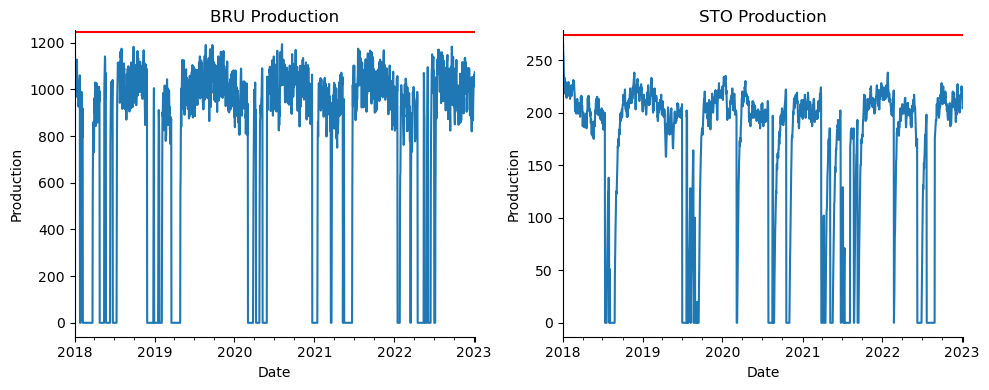

In [47]:
# Visualize production over past years (for information)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

#Function for subplots
Tools.plot_production(dfbru, ax1, 'BRU', dicmsr['BRU msr'])
Tools.plot_production(dfsto, ax2, 'STO', dicmsr['STO msr'])

plt.tight_layout()


In [48]:
# Maintenance dagen verwijderen
dfpbru = dfbru.loc[dfbru["maintenance"] == "No",:].reset_index(drop=True).copy()
dfpsto = dfsto.loc[dfsto["maintenance"] == "No",:].reset_index(drop=True).copy()

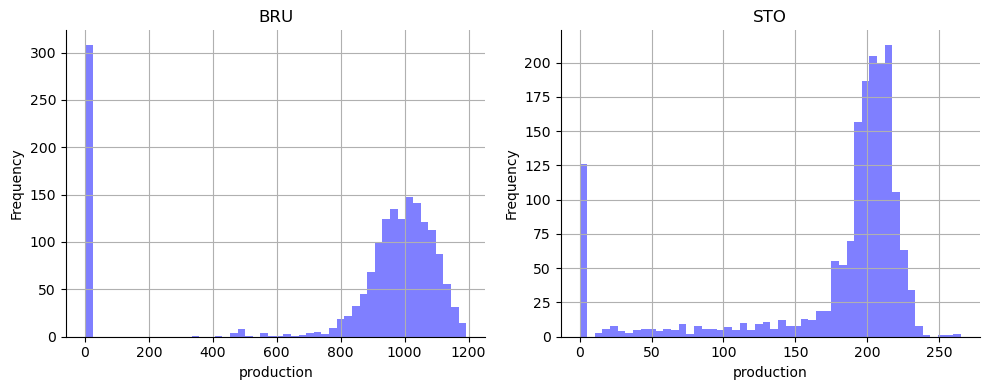

In [49]:
# Informatief histogram na verwijderen maintenance dagen
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
Tools.plot_histogram(dfpbru, "production", axs[0], "BRU")
Tools.plot_histogram(dfpsto, "production", axs[1], "STO")
plt.tight_layout()

### Verdeling bepalen voor productie van 1 dag

In [50]:
# Parameters (mean & std) bepalen van de Normale verdeling die de "niet-nul" productiedagen fit
# de "niet-nul" productiedagen : dfp.loc[dfp["production"] != 0,:]
dfpbru_not_0_model = stats.norm.fit(dfpbru.loc[dfpbru["production"] != 0,:]["production"])
dfpsto_not_0_model = stats.norm.fit(dfpsto.loc[dfpsto["production"] != 0,:]["production"])


In [51]:
# Percentage van "nul" productiedagen bepalen
bru_perc_0 = np.mean(dfpbru["production"] == 0)   # dfp["production"] == 0 is een Boolean Series
sto_perc_0 = np.mean(dfpsto["production"] == 0)   # dfp["production"] == 0 is een Boolean Series
print(f"Percentage of zero production BRU: {bru_perc_0 * 100:.2f}%")
print(f"Percentage of zero production STO: {sto_perc_0 * 100:.2f}%")


Percentage of zero production BRU: 17.74%
Percentage of zero production STO: 7.34%


## Simulatieprogramma

In [52]:
# Maak een simulatie van het Model voor de productie van 1 dag
SS = 2000
bru_simulation_prod = [Tools.model_prod(bru_perc_0, dfpbru_not_0_model[0], dfpbru_not_0_model[1]) for _ in range(SS)]
sto_simulation_prod = [Tools.model_prod(sto_perc_0, dfpsto_not_0_model[0], dfpsto_not_0_model[1]) for _ in range(SS)]
bru_simulation_prod_df = pd.DataFrame(bru_simulation_prod, columns=['production'])
sto_simulation_prod_df = pd.DataFrame(sto_simulation_prod, columns=['production'])


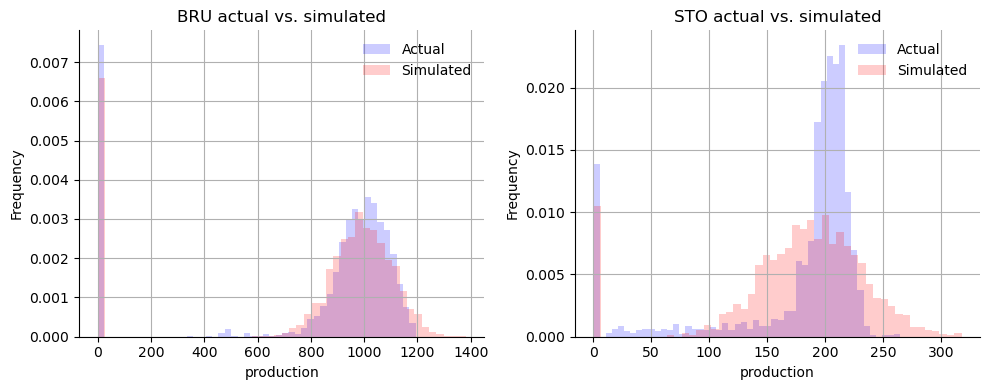

In [53]:
# Beide Density Histogrammen in 1 figuur
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot histograms for BRU
Tools.plot_histogram(dfpbru, "production", axs[0], colorp='b', alphap=0.2, densityp=True)
Tools.plot_histogram(bru_simulation_prod_df, "production", axs[0],title='BRU actual vs. simulated', colorp='r', alphap=0.2, densityp=True)

# Plot histograms for STO
Tools.plot_histogram(dfpsto, "production", axs[1], colorp='b', alphap=0.2, densityp=True)
Tools.plot_histogram(sto_simulation_prod_df, "production", axs[1], title='STO actual vs. simulated', colorp='r', alphap=0.2, densityp=True)

# Enhance the plots
axs[0].legend(['Actual', 'Simulated'])
axs[1].legend(['Actual', 'Simulated'])
plt.tight_layout()

### Simulatie van totale productie over periode van n dagen

In [81]:
n = 5
SS = 2000
bru_simulation_prodn = [sum([Tools.model_prod(bru_perc_0, dfpbru_not_0_model[0], dfpbru_not_0_model[1]) for _ in range(n)]) for k in range(SS)]
sto_simulation_prodn = [sum([Tools.model_prod(sto_perc_0, dfpsto_not_0_model[0], dfpsto_not_0_model[1]) for _ in range(n)]) for k in range(SS)]
bru_simulation_prodn_df = pd.DataFrame(bru_simulation_prodn, columns=['production'])
sto_simulation_prodn_df = pd.DataFrame(sto_simulation_prodn, columns=['production'])


2000

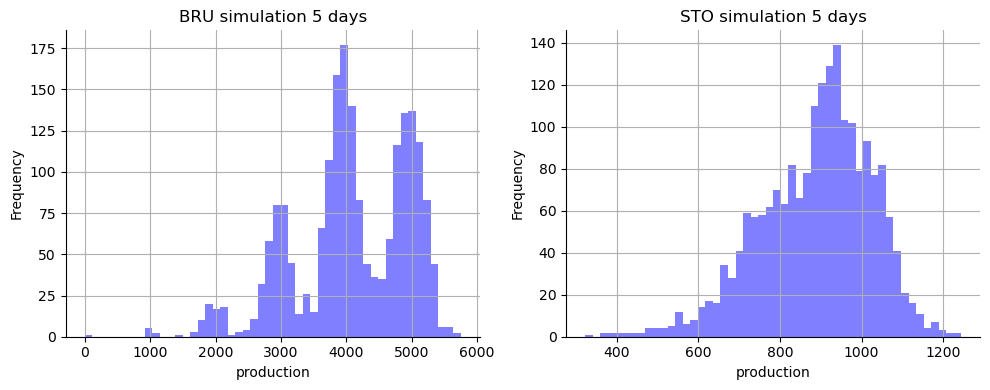

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
Tools.plot_histogram(bru_simulation_prodn_df, "production", axs[0], title=f'BRU simulation {n} days')
Tools.plot_histogram(sto_simulation_prodn_df, "production", axs[1], title=f'STO simulation {n} days')
plt.tight_layout()


In [70]:
import importlib
importlib.reload(Tools)

<module 'Tools' from 'C:\\Users\\faras\\Dropbox\\Data Scientist\\Opdracht - statistiek - visualizatie\\Repository - KF\\Scripts\\Tools.py'>

In [71]:
# Berekenen ECDF
bru_ecdf = ECDF(bru_simulation_prodn)
sto_ecdf = ECDF(sto_simulation_prodn)
brumax = n * dicmsr['BRU msr']
stomax = n * dicmsr['STO msr']

print(f"\033[4mECDF BRU: PRODUCTION FOR {n} DAYS - Theoretical maximum production for {n} days is {brumax}\033[0m")
print(f'P(x<25%): {bru_ecdf(brumax * 0.25):.3f} - Between 0 and {brumax * 0.25} hl')
print(f'P(x<50%): {bru_ecdf(brumax * 0.50):.3f} - Between 0 and {brumax * 0.50} hl')
print(f'P(x<75%): {bru_ecdf(brumax * 0.75):.3f} - Between 0 and {brumax * 0.75} hl')
print()
print(f"\033[4mECDF STO: PRODUCTION FOR {n} DAYS - Theoretical maximum production for {n} days is {stomax}\033[0m")
print(f'P(x<25%): {sto_ecdf(stomax * 0.25):.3f} - Between 0 and {stomax * 0.25} hl')
print(f'P(x<50%): {sto_ecdf(stomax * 0.50):.3f} - Between 0 and {stomax * 0.50} hl')
print(f'P(x<75%): {sto_ecdf(stomax * 0.75):.3f} - Between 0 and {stomax * 0.75} hl')
print()

ECDF BRU: PRODUCTION FOR 5 DAYS - Theoretical maximum production for 5 days is 6220
P(x<25%): 0.005 - Between 0 and 1555.0 hl
P(x<50%): 0.174 - Between 0 and 3110.0 hl
P(x<75%): 0.656 - Between 0 and 4665.0 hl

ECDF STO: PRODUCTION FOR 5 DAYS - Theoretical maximum production for 5 days is 1370
P(x<25%): 0.001 - Between 0 and 342.5 hl
P(x<50%): 0.078 - Between 0 and 685.0 hl
P(x<75%): 0.847 - Between 0 and 1027.5 hl



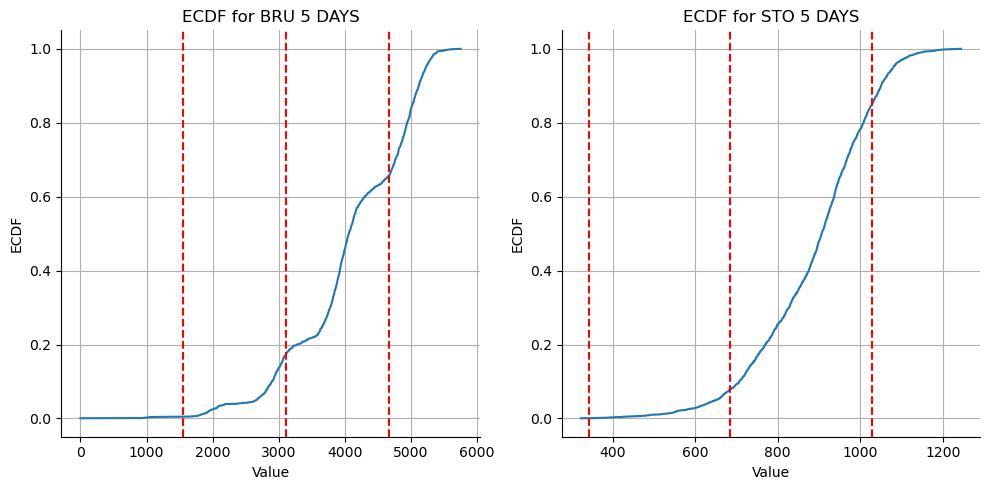

In [72]:
# Plot ECDF
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Call the plotting function for each subplot
Tools.plot_ecdf(bru_ecdf, axs[0], brumax, f'ECDF for BRU {n} DAYS')
Tools.plot_ecdf(sto_ecdf, axs[1], stomax, f'ECDF for STO {n} DAYS')
plt.tight_layout()  # Adjust layout


## Centrale limietstelling  


In [75]:
# We use the ECDF in the previous cells and compare it with a Normal CDF. As the number of days increases, we will calculate the ECDF for the production data of our case, and for a normal distribution

# Function to plot the ECDF against the theoretical normal CDF
def compare_ecdf_to_normal(data, ax, num_samples):
    # Calculate ECDF for the given data
    ecdf = ECDF(data)

    # Generate points on the x axis from the min to max of observed data
    x = np.linspace(min(data), max(data), 100)

    # Calculate the CDF of a normal distribution with the same mean and std as the data
    cdf = norm.cdf(x, np.mean(data), np.std(data))

    # Plot the ECDF and the theoretical normal CDF
    ax.plot(ecdf.x, ecdf.y, linestyle='none', marker='.', markersize=10, label='ECDF')
    ax.plot(x, cdf, label='Normal CDF')

    # Setting labels and titles
    ax.set_title(f'Comparison with n={num_samples}')
    ax.set_xlabel('Production')
    ax.set_ylabel('Cumulative Probability')
    ax.legend()


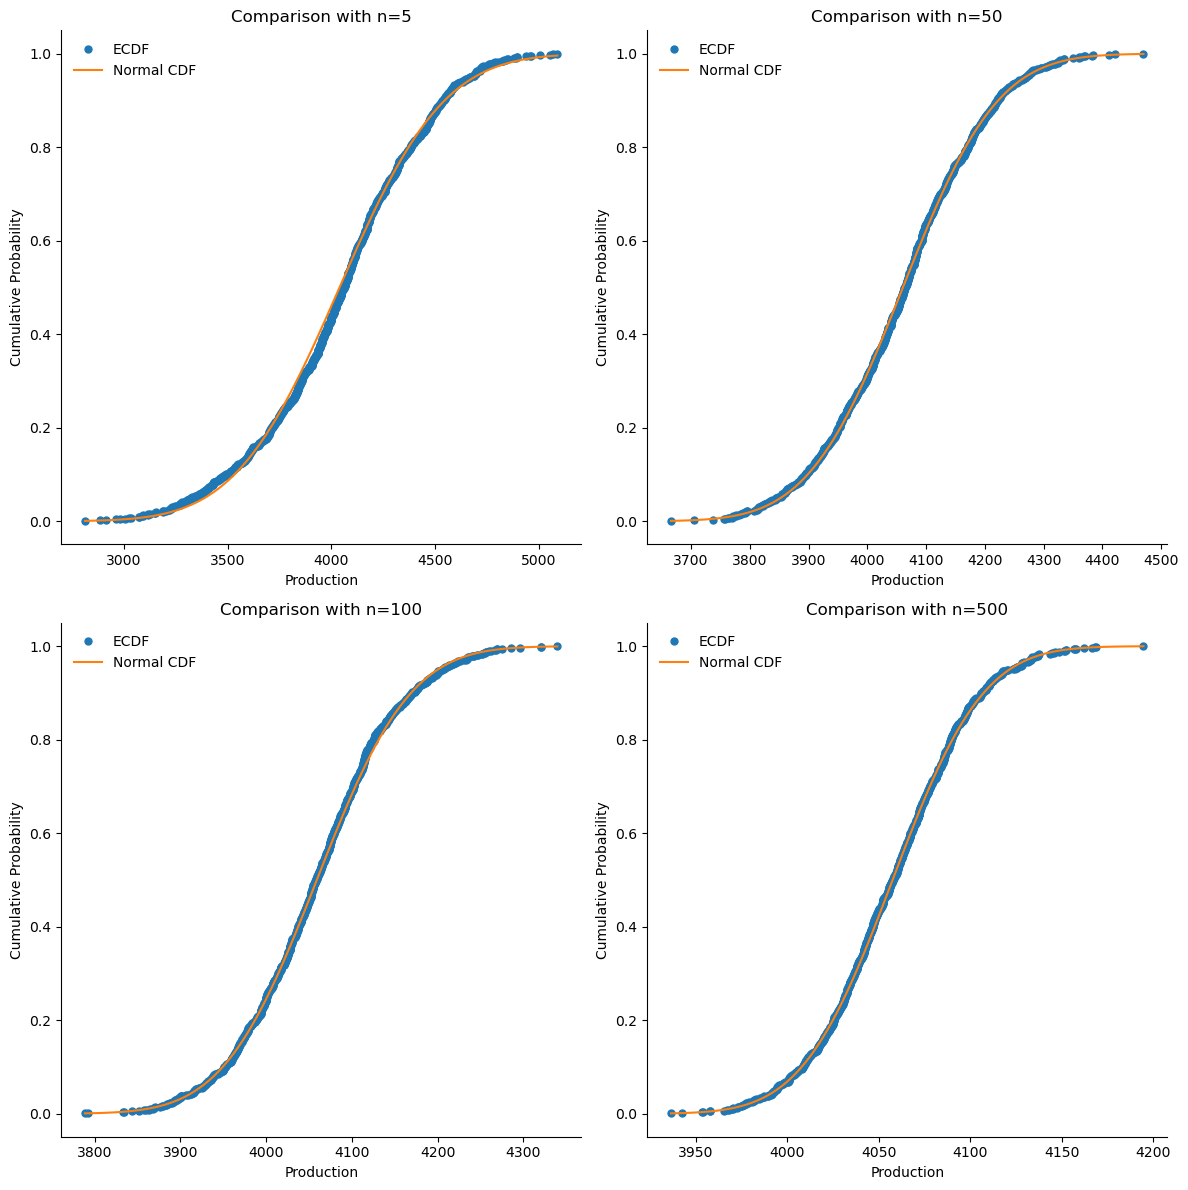

In [82]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
samples_sizes = [5, 50, 100, 500]

for ax, days in zip(axes.flatten(), samples_sizes):
    # Simulate summing up production data for 'n' days
    summed_data = [np.mean(np.random.choice(bru_simulation_prodn, days, replace=True)) for _ in range(1000)]

    # Use the function to compare ECDF to Normal CDF
    compare_ecdf_to_normal(summed_data, ax, days)

plt.tight_layout()
plt.show()
